# NeuroLoops: Exploring Feedback Loops in _C. elegans_
This project explores the role of feedback circuits in the nervous system of _C. elegans_ using the connectivity graphs in the [WormAtlas](http://www.wormatlas.org/) database.  Special thanks to Russ Poldrack for notebook starter code in his [Brain Networks Course](https://github.com/BrainNetworksCourse).

In [4]:
import pandas as pd
import numpy as np
import os, sys, operator, scipy.stats, json
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats
from networkx.algorithms import community
from collections import Counter

%matplotlib inline

# read the data from Wormatlas.org: see section 2.1 of http://www.wormatlas.org/neuronalwiring.html for details
celegans_connectome=pd.read_excel('http://www.wormatlas.org/images/NeuronConnect.xls')

INCLUDE_ELECTRIC_JUNCTIONS = False

# set up the graph
G = nx.DiGraph()
def add_edge_nbr(fn, tn, nbr):
    existing_edge = G.get_edge_data(fn, tn)
    if existing_edge is None:
        G.add_edge(fn, tn, weight=nbr)
    else:
        new_weight = existing_edge['weight'] + nbr
        G[fn][tn]['weight'] = new_weight
for i in celegans_connectome.index:
    entry = celegans_connectome.loc[i]
    fn = entry['Neuron 1']
    tn = entry['Neuron 2']
    nbr = entry['Nbr']
    typ = entry['Type']
    if typ in ['S','Sp']:
        add_edge_nbr(fn,tn,nbr)
    if typ == 'EJ' and INCLUDE_ELECTRIC_JUNCTIONS:
        add_edge_nbr(fn,tn,nbr)
        add_edge_nbr(tn,fn,nbr)

GTEMP = G.copy()
G = GTEMP
if False:
    nx.write_graphml(G, 'celegans.graphml')

In [5]:
# Utility Functions

def get_weight_histogram(graph):
    ''' Build a histogram of weights from a weighted graph '''
    return dict(Counter([graph[e[0]][e[1]]['weight'] for e in list(graph.edges)]))

def get_node_cluster_map(cluster_nodes):
    ''' Invert a cluster_node set to map node names to cluster index '''
    node_cluster_map = {}
    for cluster in range(len(cluster_nodes)):
        for node in cluster_nodes[cluster]:
            node_cluster_map[node] = cluster
    return node_cluster_map

def count_cycles(graph, cutoff=1e7):
    i = 0
    for c in nx.simple_cycles(graph):
        i += 1
        if i > cutoff:
            return '> {}'.format(cutoff)
    return str(i)

# Courtesy Russ Poldrack
def plot_adjmtx(G,bin=False):
    A = nx.to_numpy_array(G,weight='weight')
    if bin:
        A = (A>0).astype('int')
        cmap='gray'
    else:
        cmap='viridis'
    A = pd.DataFrame(A,columns=list(G.nodes),index=list(G.nodes))
    
    plt.imshow(A,cmap=cmap)
    if not bin:
        plt.colorbar()
    # set the axes to use name labels rather than numbers
    ax=plt.gca()
    node_list=list(G.nodes) 
    ax.set_yticks(np.arange(len(node_list)))
    ax.set_xticks(np.arange(len(node_list)))
    ax.set_xticklabels(node_list)
    ax.set_yticklabels(node_list)
    # add grid lines
#     for i in range(len(node_list)):
#         ax.axvline(x=i-0.5,color='b')
#         ax.axhline(y=i-0.5,color='b')

# Questions & Hypothesis
I was curious about cycles because of their relevance to persistent state representation.  This yielded the following questions about cycles in the _C. elegans_ neural graph:
- Does cyclicity vary for each community?
- Is the rich club more cyclic than the organism as a whole?
- What types of neurons tend to have more cyclicity?
- Are there common junctions in the larger cycles?
- Do the neurons that make up cycles vary in community or type?

For reference, below is a plot of the overall neural graph of _C. elegans_:

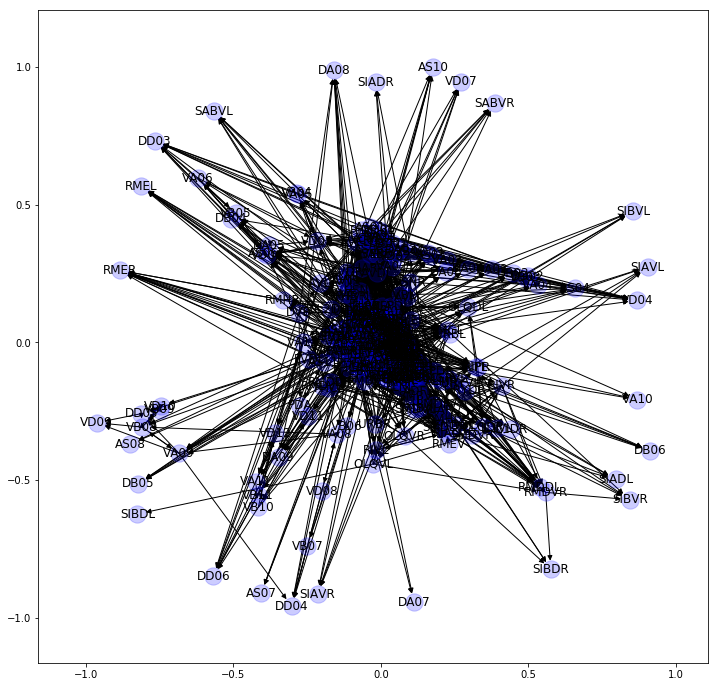

In [6]:
# Build plot
plt.figure(figsize=(12,12))
edge_expansion=12
node_expansion=30
layout = nx.spring_layout(G)
#weights=nx.get_edge_attributes(G,'weight')
_=nx.draw_networkx_edges(G,pos=layout, )
#                      width=[weights[i]*edge_expansion for i in G.edges],alpha=0.3)
_=nx.draw_networkx_nodes(G,pos=layout,
                         node_color='blue',
                         alpha=0.2,)
                        #node_size=[G.out_degree[i]*node_expansion for i in G.nodes]*node_expansion)
_=nx.draw_networkx_labels(G,pos=layout)

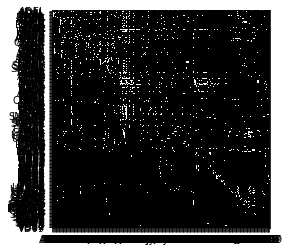

In [42]:
plot_adjmtx(G, True)

# Too Many Cycles
I first tried to search for all cycles by brute force, but this filled up my hard drive and crashed after identifying over 6 million cycles (over 11 gigabytes of cycles with no compression).  This meant analysis of cycles individually would be intractable for me.

In [ ]:
raise NotImplementedError  # This cell is not meant to be run!
with open('cycles.txt','a') as f:
    f.write('cycles = [\n')
    i = 0
    for c in nx.simple_cycles(G):
        line = '{},'.format(repr(c).replace(' ',''))
        f.write(line)
        i += 1
        if i % 1e5 == 0:
            print('Found {} cycles'.format(i))
        f.write(']\n\n\n')

# Clustering

### Girvan-Newman Clustering
My first test of clustering the graph used Girvan-Newman clustering to find communities.  This didn't work super well as a clustering method because the majority of the first clusters it found were single-node clusters.  However, this alone was interesting, and raised an interesting question: how is it that the edges out of a single node can have the highest betweenness centrality even when most of the edges connecting it have been removed?  I put this question on the back burner.

In [35]:
gn_clusters_gen = community.centrality.girvan_newman(G)
gn_clusters = None
for i in range(15):
    gn_clusters = next(gn_clusters_gen)
    print('Iteration {} yielded communities of sizes {}'.format(i+1, [len(c) for c in gn_clusters]))
    
# gn_cluster_gen = community.centrality.girvan_newman(G)
# # for i in range(10):
# #     gn_clusters = next(gn_cluster_gen)
# for gn_clusters in gn_cluster_gen:
#     gn_clusters = list(gn_cluster_gen).sort(reverse=True, key=len)
#     print('Iteration {} yielded communities of sizes {}'.format(i+1, 
#                                             [len(c) for c in gn_clusters]))

Iteration 1 yielded communities of sizes [271, 8]
Iteration 2 yielded communities of sizes [266, 5, 8]
Iteration 3 yielded communities of sizes [265, 5, 8, 1]
Iteration 4 yielded communities of sizes [264, 5, 8, 1, 1]
Iteration 5 yielded communities of sizes [263, 1, 5, 8, 1, 1]
Iteration 6 yielded communities of sizes [89, 174, 1, 5, 8, 1, 1]
Iteration 7 yielded communities of sizes [89, 153, 21, 1, 5, 8, 1, 1]
Iteration 8 yielded communities of sizes [89, 146, 21, 7, 1, 5, 8, 1, 1]
Iteration 9 yielded communities of sizes [89, 144, 21, 7, 2, 1, 5, 8, 1, 1]
Iteration 10 yielded communities of sizes [89, 143, 21, 7, 2, 1, 1, 5, 8, 1, 1]
Iteration 11 yielded communities of sizes [86, 143, 21, 7, 3, 2, 1, 1, 5, 8, 1, 1]
Iteration 12 yielded communities of sizes [86, 142, 21, 7, 3, 1, 2, 1, 1, 5, 8, 1, 1]
Iteration 13 yielded communities of sizes [86, 141, 21, 7, 3, 1, 2, 1, 1, 1, 5, 8, 1, 1]
Iteration 14 yielded communities of sizes [86, 140, 21, 7, 3, 1, 2, 1, 1, 1, 5, 1, 8, 1, 1]
Itera

In [36]:
cluster_nodes = []
for c in gn_clusters:
    sub = G.subgraph(c)
    cluster_nodes.append(sub)
    Gc = nx.compose(Gc, sub)
cluster_nodes.sort(key=len, reverse=True)
print('Cluster sizes: {}'.format([len(c) for c in cluster_nodes]))

Cluster sizes: [140, 84, 21, 8, 7, 5, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1]


### Label Propagation Clustering
I tried Label Propagation Clustering, but it did not terminate after an hour of computation.

In [33]:
lpa_clusters = community.label_propagation.asyn_lpa_communities(G)
Gc = nx.DiGraph()
cluster_nodes = []
for c in mod_clusters:
    sub = G.subgraph(c)
    cluster_nodes.append(sub)
    Gc = nx.compose(Gc, sub)
print('Cluster sizes: {}'.format([len(c) for c in cluster_nodes]))

KeyboardInterrupt: 

### Greedy Modularity Clustering
Next, I tried greedy modularity clustering, which identified 12 communities, the largest of which contained 41 nodes.  Only one cluster had just a single node.  I felt this would be adequate as a starting point.

In [51]:
mod_clusters = community.modularity_max.greedy_modularity_communities(G)
Gc = nx.DiGraph()
cluster_nodes = []
for c in mod_clusters:
    sub = G.subgraph(c)
    cluster_nodes.append(sub)
    Gc = nx.compose(Gc, sub)
print('Cluster sizes: {}'.format([len(c) for c in cluster_nodes]))

IndexError: list index out of range

# Clusters to Graph
Given a clustering, I wanted to see what the connectivity between those clusters looked like.  For my first test, I simply included a directed edge between two clusters if there was a single edge of that direction between two nodes within those clusters.

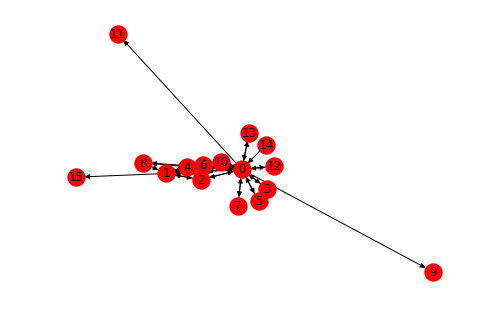

In [37]:
# Build a cluster lookup map indexed by node name
node_cluster_map = get_node_cluster_map(cluster_nodes)
C = nx.DiGraph()
for i in range(len(cluster_nodes)):
    C.add_node(i)
for edge in list(G.edges):
    from_cluster = node_cluster_map[edge[0]]
    to_cluster = node_cluster_map[edge[1]]
    if from_cluster != to_cluster:
        C.add_edge(from_cluster, to_cluster)
nx.draw_spring(C, with_labels=True)

This isn't particularly useful: every cluster has a bidirectional connection to almost every other.  I then tried weighting these connections by the number of connections between them.  This was interesting, as it revealed that the majority of possible cluster-to-cluster edges were instantiated by only a few edges in the full graph, whereas some connections were duplicated nearly 100 times.

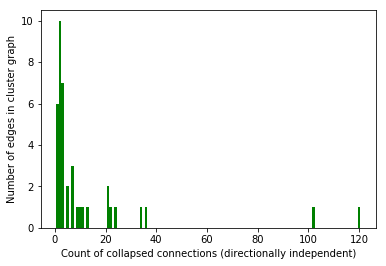

In [38]:
node_cluster_map = get_node_cluster_map(cluster_nodes)
C = nx.DiGraph()
for i in range(len(cluster_nodes)):
    C.add_node(i)
for edge in list(G.edges):
    from_cluster = node_cluster_map[edge[0]]
    to_cluster = node_cluster_map[edge[1]]
    if from_cluster != to_cluster:
        existing_edge = C.get_edge_data(from_cluster, to_cluster)
        if existing_edge is None:
            C.add_edge(from_cluster, to_cluster, weight=1)
        else:
            new_weight = existing_edge['weight'] + 1
            C[from_cluster][to_cluster]['weight'] = new_weight

weight_hist = get_weight_histogram(C)
width = 1.0     
plt.bar(weight_hist.keys(), weight_hist.values(), width, color='g')
plt.xlabel('Count of collapsed connections (directionally independent)')
plt.ylabel('Number of edges in cluster graph')
plt.show()

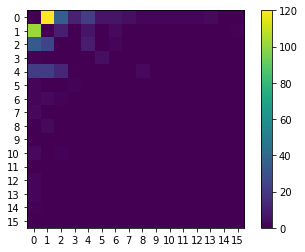

In [50]:
plot_adjmtx(C, False)

Quite interesting: most connections between clusters are weak, but there are some strongly connected outliers.  Let's see what happens if, for each edge, the direction and weight are determined by the difference between connections going each direction.

In [ ]:
node_cluster_map = get_node_cluster_map(cluster_nodes)
C = nx.DiGraph()
for i in range(len(cluster_nodes)):
    C.add_node(i)
for edge in list(G.edges):
    from_cluster = node_cluster_map[edge[0]]
    to_cluster = node_cluster_map[edge[1]]
    if from_cluster != to_cluster:
        existing_edge = C.get_edge_data(from_cluster, to_cluster)
        if existing_edge is None:
            C.add_edge(from_cluster, to_cluster, weight=1)
        else:
            new_weight = existing_edge['weight'] + 1
            C[from_cluster][to_cluster]['weight'] = new_weight

weight_hist = get_weight_histogram(C)
width = 1.0     
plt.bar(weight_hist.keys(), weight_hist.values(), width, color='g')
plt.show()

# Community Subgraphs

In [43]:
comgs = []
for cluster in range(len(cluster_nodes)):
    comgs.append(G.subgraph(cluster_nodes[cluster]))

print([len(c) for c in comgs])

[140, 84, 21, 8, 7, 5, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1]


In [49]:
for sub in range(len(comgs)):
    print('Index={}, cycles = {}'.format(sub, count_cycles(comgs[sub])))

Index=0, cycles = > 10000000.0
Index=1, cycles = > 10000000.0
Index=2, cycles = 7010
Index=3, cycles = 11
Index=4, cycles = 4
Index=5, cycles = 0
Index=6, cycles = 1
Index=7, cycles = 0
Index=8, cycles = 0
Index=9, cycles = 0
Index=10, cycles = 0
Index=11, cycles = 0
Index=12, cycles = 0
Index=13, cycles = 0
Index=14, cycles = 0
Index=15, cycles = 0


The larger subgraphs have too many cycles to be useful.  Let's examine only subgraphs indexed 6 through 10.

In [52]:
def analyze_subgraph(g):
    cycles = []
    for c in nx.simple_cycles(g):
        x = {
            'nodes':c,
            'ct':len(c),
        }
        print(x)
    

analyze_subgraph(comgs[3])

{'nodes': ['VD08', 'VA08'], 'ct': 2}
{'nodes': ['VA09', 'VB08'], 'ct': 2}
{'nodes': ['VA09', 'DD05', 'VB08'], 'ct': 3}
{'nodes': ['VB09', 'VD10'], 'ct': 2}
{'nodes': ['VB09', 'VD10', 'DD05', 'VB08'], 'ct': 4}
{'nodes': ['VB09', 'VB08', 'VD10'], 'ct': 3}
{'nodes': ['VB09', 'VB08'], 'ct': 2}
{'nodes': ['VB09', 'DD05', 'VB08', 'VD10'], 'ct': 4}
{'nodes': ['VB09', 'DD05', 'VB08'], 'ct': 3}
{'nodes': ['VD10', 'DD05', 'VB08'], 'ct': 3}
{'nodes': ['DD05', 'VB08'], 'ct': 2}


### Cycle Count Normalization
To normalize cycle counts against possible counts, I needed to compute the total number of cycles possible in each group.  I considered both formulas on [this StackExchange question](https://math.stackexchange.com/questions/1363963/number-of-cycles-in-complete-graph), and settled on William Swartworth's equation: $C_{total} = 2\sum_{i=1}^{3} \frac{k!}{(k - i)!\cdot 2i} $ where $k=$ the number of nodes.

# Rich Club Cycles


RC has 10 nodes with cutoff 50


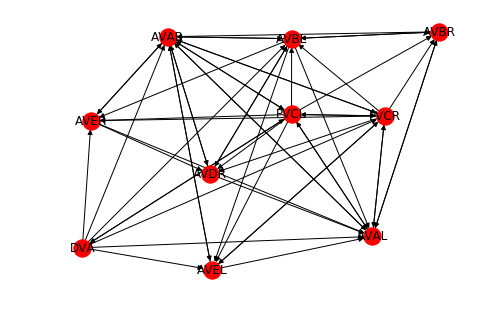

In [47]:
cutoff=50
G_highdegree=G.copy()
deg = dict(G_highdegree.degree())
to_remove = [n for n in deg if deg[n] <= cutoff]
G_highdegree.remove_nodes_from(to_remove)
print('RC has {} nodes with cutoff {}'.format(len(G_highdegree.nodes),cutoff))
nx.draw_spring(G_highdegree, with_labels=True)

In [48]:
print('Number of cycles within rich club = {}'.format(count_cycles(G_highdegree)))

Number of cycles within rich club = 2884
